### Solution to flowering.txt on logistic regression
<code>flowering.txt</code>

#### 0. Load the dataset, make some plots

In [1]:
# LOAD DATASET
flowering<-read.table('flowering.txt', header=T)
names(flowering)
head(flowering)

[1] "State"   "Flowers" "Root"

State,Flowers,Root
0,165,1.57
0,41,0.20
0,33,0.20
0,141,0.91
0,150,2.36
0,21,0.20


State is the response, binary, and Flowers and Root are the two (continuous) explanatory variables. Let us make some scatter plots to visualise these variables. 

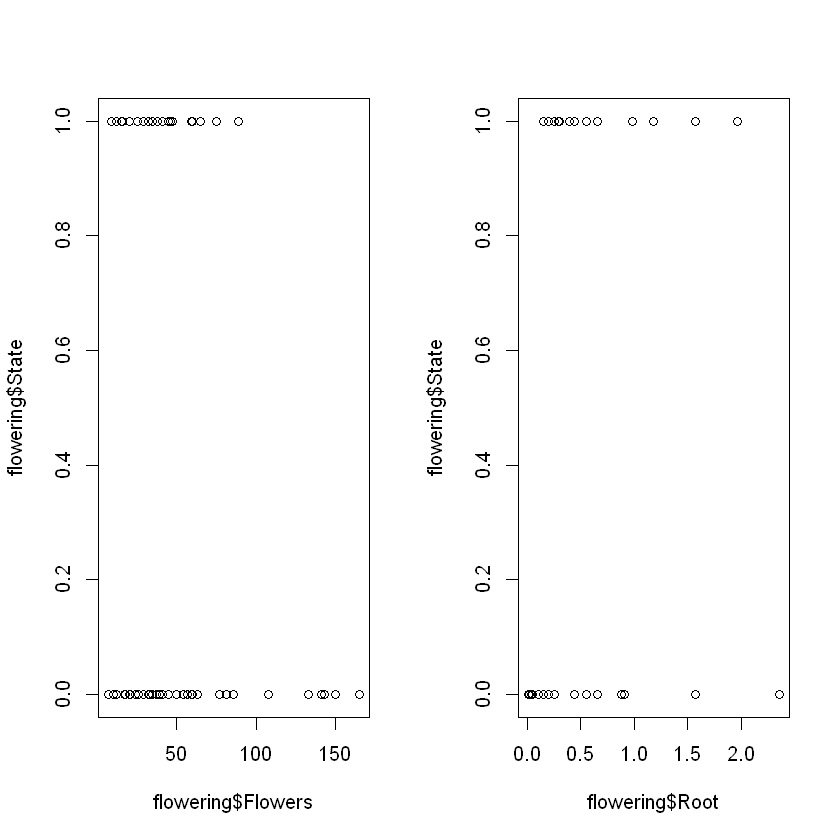

In [2]:
# PLOTS
par(mfrow=c(1,2))
plot(flowering$Flowers, flowering$State)
plot(flowering$Root, flowering$State)

As expected, plots of binary outcomes only give you two rows of dots... 

#### 1. Logistic regression with the main effects only
Next we fit a logistic regression to the dataset with the two main explanatory variables. First, we define the log-likelihood function: 

In [3]:
# THE FIRST LOGISTIC LOG-LIKELIHOOD MODEL
logistic.log.likelihood<-function(parm, dat)
{
# DEFINE PARAMETERS
a<-parm[1]
b<-parm[2]
c<-parm[3]
    
# DEFINE RESPONSE VARIABLE, WHICH IS THE FIRST COLUMN OF dat. HAS TO BE 0 OR 1 (BINARY RESPONSE)
State<-dat[,1]
# DEFINE THE TWO EXPLANATORY VARIABLES, CONTINUOUS
Flowers<-dat[,2]
Root<-dat[,3]

# MODEL THE PROBABILITY OF SURVIVAL FOR EACH INDIVIDUAL
# WHICH IS THE EXPIT TRANSFORMATION OF THE LINEAR PREDICTORS
p<-exp(a+b*Flowers+c*Root)/(1+exp(a+b*Flowers+c*Root))

# THE LOG-LIKELIHOOD FUNCTION
log.like<-State*log(p)+(1-State)*log(1-p)

# THE OVERALL LOG-LIKELIHOOD IS THE SUM OF THE LOG-LIKELIHOODS OF THE OBSERVATIONS
return(sum(log.like))
}

In [4]:
# TEST CASE
logistic.log.likelihood(c(0,0,0), dat=flowering)

[1] -40.89568

The linear predictor is $a+b*Flowers+c*Root$, and we relate the probabaility of success (alive) $p$ with the linear predictor via expit transformation. 

The next step is to find a set of $(\hat{a}, \hat{b}, \hat{c})$ that maximises the log-likelihood. We call the output M1. I am using the default algorithm here because 1) it is simple, and 2) the parameters can be any real numbers without the need of an upper and lower bound (unlike yesterday's, that $\sigma$ has to be positive). 

In [5]:
M1<-optim(c(0,0,0), logistic.log.likelihood, 
          dat=flowering, control=list(fnscale=-1))
M1

$par
[1]  0.9616543 -0.1064110  6.5998455

$value
[1] -27.03405

$counts
function gradient 
     220       NA 

$convergence
[1] 0

$message
NULL

<code>optim()</code> returns a list. To retrieve the parameter estimates (i.e. the set of parameter values where the log-likelihood attains its maximum) we visit the <code>\$par</code> element. <code>\$value</code> gives maximised log-likelihood value. 

Some of you ran into problems while setting the initial condition which is typical. One possibility is that the intial condition lies outside the box of constraints (if <code>L-BFGS-B</code> is used). Another common issue is that the log-likelihood at the initial condition is too small (say, -Inf, smaller than the smallest number R can understand). In this case, the neighbourhood of the initial condition is also -Inf, and <code>optim()</code> does not know which direction it should go next. In other words,  you are too far from the peak. Imagine you're trying to find the peak of Yr Wyddfa (Snowdon) but your starting point is at Silwood... In practice I recommend running multiple <code>optim()</code> with different initial conditions to ensure they all converge to the global maximum. 

#### 2. Logistic regression with the interaction term
Some suggest that the interaction between Flowers and Root may be meaningful. It is easy to incorporate the interaction term by changing the linear predictor to $a+b*Flower+c*Root+d*Interaction$, where $Interaction=Flower*Root$. 

Note that it becomes a 4-parameter model. You will obtain a new set of parameters that maximises the log-likelihood, and a new and larger maximised log-likelihood value. We store the result in M2. 

In [6]:
# LOGISTIC REGRESSION LOG-LIKELIHOOD MODEL WITH INTERACTION TERM
# ONE EXTRA PARAMETER d FOR THE COEFFICIENT OF THE INTERACTION
logistic.log.likelihood.int<-function(parm, dat)
{
# DEFINE PARAMETERS, ONE MORE THIS TIME
a<-parm[1]
b<-parm[2]
c<-parm[3]
d<-parm[4]

# DEFINE RESPONSE VARIABLE, WHICH IS THE FIRST COLUMN OF dat
State<-dat[,1]
# DEFINE EXPLANATORY VARIABLES
Flowers<-dat[,2]
Root<-dat[,3]
Interaction<-dat[,2]*dat[,3]

# MODEL OUR SUCCESS PROBABILITY
# REMEMBER TO INCLUDE THE INTERACTION TERM
p<-exp(a+b*Flowers+c*Root+d*Interaction)/(1+exp(a+b*Flowers+c*Root+d*Interaction))

# THE LOG-LIKELIHOOD FUNCTION FOR A SINGLE DATA POINT
log.like<-State*log(p)+(1-State)*log(1-p)

# THE OVERALL LOG-LIKELIHOOD IS THE SUM OF THE LOG-LIKELIHOODS OF THE OBSERVATIONS
return(sum(log.like))
}

In [7]:
# MAXIMISE THIS LOG-LIKELIHOOD IN THE FOUR-DIMENSIONAL PARAMETER SPACE
M2<-optim(c(0,0,0,0), logistic.log.likelihood.int, dat=flowering, control=list(fnscale=-1))
M2

$par
[1] -2.95944410 -0.07889339 25.14474413 -0.20898731

$value
[1] -18.56411

$counts
function gradient 
     389       NA 

$convergence
[1] 0

$message
NULL

#### 3. Hypothesis testing for the interaction term
The two models are nested as the M1 is a special case of M2 (with $d=0$). Hence we perform a LRT to test for the significance of the interaction term. First we calculate $D$, the LRT statistic. 

In [8]:
# THE LIKELIHOOD RATIO TEST STATISTIC
# D MEASURES THE DIFFERENCE IN EXPLANATORY POWER BETWEEN THE TWO MODELS
D<-2*(M2$value - M1$value)
D

[1] 16.93988

Is this $D$ large or small? We compare it to the critical value of a $\chi^2$ distribution. The degree(s) of freedom equal the difference in the number of parameters, which is one in our case. 

In [9]:
# CRITICAL VALUE
qchisq(0.95, df=1)

[1] 3.841459

Since $D$ is larger than the critical value, there is a huge drop in explanatory power when the interaction term is removed. In other words, we want to keep the interaction term, and that the parameter $d$ is significant (i.e. signficantly different from zero).

Alternatively we can calculate the p-value:

In [10]:
# p-value
1-pchisq(D, df=1)

[1] 3.85824e-05

#### 4. Profile likelihood
Profiling is a procedure to find C.I. for a subset of parameters in a multi-parameter model. In M2, we obtained the mle $(\hat{a}, \hat{b}, \hat{c}, \hat{d})$. If we move any parameter(s) away from their mle, the log-likelihood drops. If our interest is on the profile C.I. of $b$, the coefficient of flowers, then it makes sense to ask what the profile likelihood is at $b=-0.03$ (say). Some may think that it is the log-likelihood value at $b=-0.03$, while keeping the remaining three parameters at the mle:

In [11]:
# THE WRONG APPROACH. SET b=-0.03, AND KEEP ALL OTHERS AT THEIR MLE
logistic.log.likelihood.int(parm=c(M2$par[1], -0.03, M2$par[3], M2$par[4]), dat=flowering)

[1] -28.34523

WRONG! There is no guarantee that the descend of the log-likelihood follows a straight path along $b$. The correct procedure is to fix $b=-0.03$ and re-maximise the log-likelihood with respect to the remaining three parameters. This is what we meant by performing a partial maximisation of the log-likelihood in the restricted parameter space. Below is the function to calculate the profile log-likelihood for $b$:

In [12]:
# PROFILE LOG-LIKELIHOOD FOR b. OBVIOUSLY IT IS A FUNCTION OF b
profile.log.likelihood<-function(b)
{
f<-function(parm_acd) 
    {
    logistic.log.likelihood.int(c(parm_acd[1], b, 
        parm_acd[2], parm_acd[3]), dat=flowering)
    }
temp<-optim(c(0, 0, 0), f, control=list(fnscale=-1))
return(temp$value)
}

And now we can evaluate the profile log-likelihood at $b=-0.03$:

In [13]:
# PROFILE LOG-LIKELIHOOD VALUE FOR b AT b=-0.03
profile.log.likelihood(b=-0.03)

[1] -19.3901

It is obvious that the profile log-likelihood is larger than the one from the wrong approach. Now we calculate the profile log-likelihood for a range of $b$ values. Note that each point on the profile log-likelihood is a partial optimisation: 

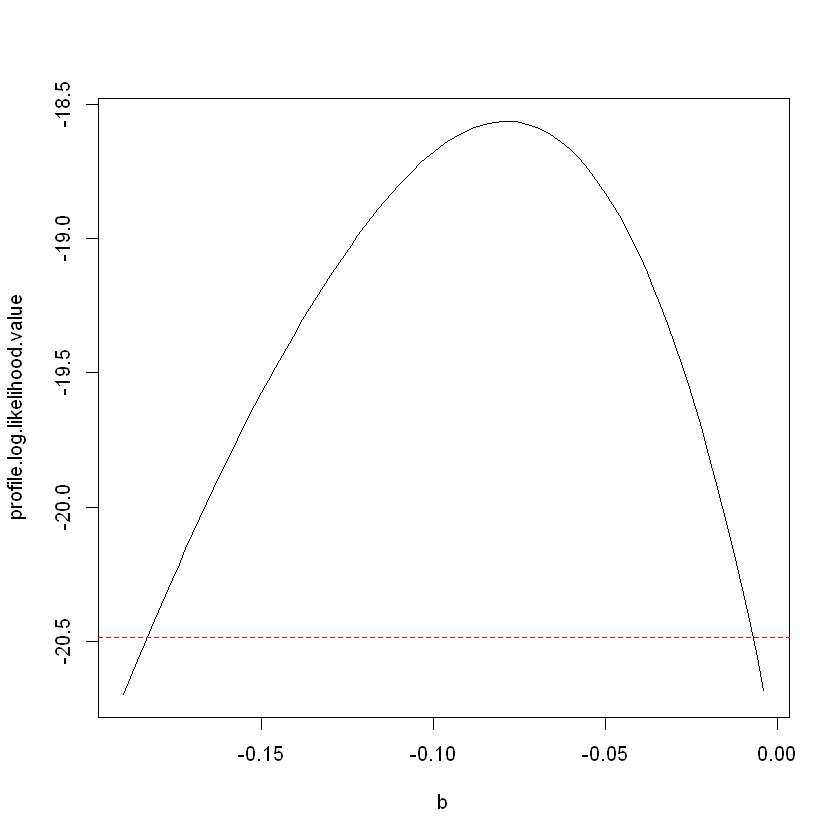

In [14]:
# PLOT THE PROFILE LOG-LIKELIHOOD FOR A RANGE OF b, USUALLY AROUND ITS MLE
b<-seq(-0.19, -0.004, 0.002)
profile.log.likelihood.value<-rep(NA, length(b))
for (i in 1:length(b))
{profile.log.likelihood.value[i]<-profile.log.likelihood(b[i])}

# PLOT THE PROFILE LOG-LIKELIHOOD
plot(b, profile.log.likelihood.value, type='l')
# DRAW A HORIZONTAL LINE WHICH IS 1.92 UNITS BELOW THE MAXIMUM
abline(h=M2$value-1.92, col='red', lty=2)

The upper and lower C.I. are where the profile log-likelihood and the horizontal red dotted line (-1.92 units from the global peak) meet. You may use <code>uniroot()</code>, to find the two points (roots) if you are not satisfied with the eyeball method. The idea is to create a new function <code>f</code> which first calculates the relative log-likelihood (compared to the maximum), and then adds 1.92 units to it so <code>f</code> will become 0 when we are at the lower/upper C.I.. Besides, because there are two roots but <code>uniroot()</code> only gives you one at a time, you need to find the two bounds separately. For instance, the lower C.I. lies between -0.2 and the mle. 

In [15]:
f<-function(b) {profile.log.likelihood(b)-M2$value+1.92}
# LOWER C.I.
uniroot(f, interval=c(-0.2, M2$par[2]))$root
# UPPER C.I.
uniroot(f, interval=c(M2$par[2], 0))$root

[1] -0.1831428

[1] -0.007224048

#### 5. C.I. for $b$ with normality
Let us fit M2 again with <code>hessian=T</code>. 

In [16]:
# MAXIMISE THIS LOG-LIKELIHOOD IN THE FOUR-DIMENSIONAL PARAMETER SPACE
M2<-optim(c(0,0,0,0), logistic.log.likelihood.int, 
          dat=flowering, control=list(fnscale=-1), hessian=T)
M2$hessian

-5.878141,-197.78814,-2.030139,-90.22500
-197.788144,-8511.39907,-90.197652,-4882.85554
-2.030139,-90.19765,-1.073765,-62.28382
-90.225002,-4882.85554,-62.283816,-4112.10256


The variance-covariance matrix is the negative inverse of the Hessian matrix. Since $b$ is the second parameter its approximate variance is the [2,2] element, which is 0.00176. 

In [17]:
# THE VARIRANCE-COVARIANCE MATRIX
vcov<-(-1)*solve(M2$hessian)
vcov

2.33215204,-0.0270341898,-8.50149031,0.1096983538
-0.02703419,0.0017612670,-0.08178689,-0.0002594422
-8.50149031,-0.0817868894,61.12136432,-0.6421219409
0.10969835,-0.0002594422,-0.64212194,0.0078702049


In [18]:
# LOWER C.I. FOR b
M2$par[2]-1.96*sqrt(vcov[2,2])
# UPPER C.I. FOR b
M2$par[2]+1.96*sqrt(vcov[2,2])

[1] -0.1611496

[1] 0.003362811

#### 6. [Extra] Running the same analysis with glm()
Unsurprisingly you can perform the same analysis with <code>glm()</code>. Let us fit M1 and M2 with <code>glm</code>:

In [19]:
# THE FIRST MODEL WITH THREE PARAMETERS. PARAMETER ESTIMATES ARE THE SAME AS ABOVE
glm.M1<-glm(State~Flowers+Root, family='binomial', data=flowering)
summary(glm.M1)


Call:
glm(formula = State ~ Flowers + Root, family = "binomial", data = flowering)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4296  -0.7899  -0.1879   0.7291   2.3596  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.96152    0.61676   1.559  0.11900   
Flowers     -0.10642    0.03343  -3.183  0.00146 **
Root         6.60042    2.10051   3.142  0.00168 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 78.903  on 58  degrees of freedom
Residual deviance: 54.068  on 56  degrees of freedom
AIC: 60.068

Number of Fisher Scoring iterations: 6


In [20]:
# THE SECOND MODEL WITH INTERACTION
glm.M2<-glm(State~Flowers*Root, family='binomial', data=flowering)
summary(glm.M2)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = State ~ Flowers * Root, family = "binomial", data = flowering)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.74546  -0.44295  -0.03424   0.46458   2.69443  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)   
(Intercept)  -2.96010    1.53257  -1.931  0.05343 . 
Flowers      -0.07889    0.04197  -1.880  0.06013 . 
Root         25.14934    7.84162   3.207  0.00134 **
Flowers:Root -0.20905    0.08930  -2.341  0.01924 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 78.903  on 58  degrees of freedom
Residual deviance: 37.128  on 55  degrees of freedom
AIC: 45.128

Number of Fisher Scoring iterations: 9


In defining the glm formula we use <code>State~Flowers*Root</code> to include the interaction term (with the main effects autoamtically included). The residual deviance reported in <code>glm()</code> is simply (-2) times the maximised log-likelihood. All parameter estimates are almost identical (rounding errors may exist). 

We compare the two models by <code>anova()</code> with a LRT:

In [21]:
# LRT FOR MODEL COMPARISON
anova(glm.M1, glm.M2, test='LRT')

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
56,54.06811,NA,NA,NA
55,37.12823,1,16.93988,3.858239e-05


Aha! We meet our $D$ statistic again from the ANOVA table, with df=1. The small p-value confirms the significance of the interaction term.  

##### 7. [Extra] Profile and Wald C.I. with <code>glm()</code>
I must admit that I seldom use <code>confint()</code> but my impression is that it performs profiling from <code>lm(), glm(), glmer()</code> objects. I think we got the same results here. 

In [22]:
confint(glm.M2, 2, trace=T)

Waiting for profiling to be done...

Parameter: Flowers down
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Parameter: Flowers up
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

2.5 %       97.5 % 
-0.183176610 -0.007218581

For the Wald C.I. for $b$, its standard error is 0.04197 from <code>summary(M2)</code>. Note that 0.04197^2=0.00176 which is the [2,2] element of our variance-covariance matrix. 